# Digit recogniser

In this exercise, we will train a model to recognise handwritten digits, based on the MNIST dataset. We will first do this using the `fastai` library, and then we'll unpeel the layers one by one to see how it works in PyTorch. This top-down approach is in contrast to the bottom-up approach taken in [fastbook chapter 4](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb).

## Install dependencies
- `fastai` - machine learning library
- `matplotlib` - used for displaying test data

In [ ]:
!pip3 install fastai matplotlib

## Download the MNIST dataset

The MNIST dataset consists of images of handwritten digits. We download it from the [MNIST database](http://yann.lecun.com/exdb/mnist/) and unpack it into the `training-data` directory:

In [1]:
import os
import gzip
import requests
import numpy as np
from PIL import Image

# URLs for the train image and label data
url_train_img = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
url_train_lbl = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'

# download and decompress the files
def download_and_decompress(url):
    response = requests.get(url, stream=True)
    return gzip.decompress(response.content)

train_img = download_and_decompress(url_train_img)
train_lbl = download_and_decompress(url_train_lbl)

# convert to numpy arrays
train_img = np.frombuffer(train_img, dtype=np.uint8, offset=16).reshape(-1, 28, 28)
train_lbl = np.frombuffer(train_lbl, dtype=np.uint8, offset=8)

# create directories for each digit
for i in range(10):
    os.makedirs(f'../../training-data/mnist/{i}', exist_ok=True)

# save each image in the appropriate directory
for i in range(len(train_img)):
    Image.fromarray(train_img[i]).save(f'../../training-data/mnist/{train_lbl[i]}/{i}.png')

## Show some example images

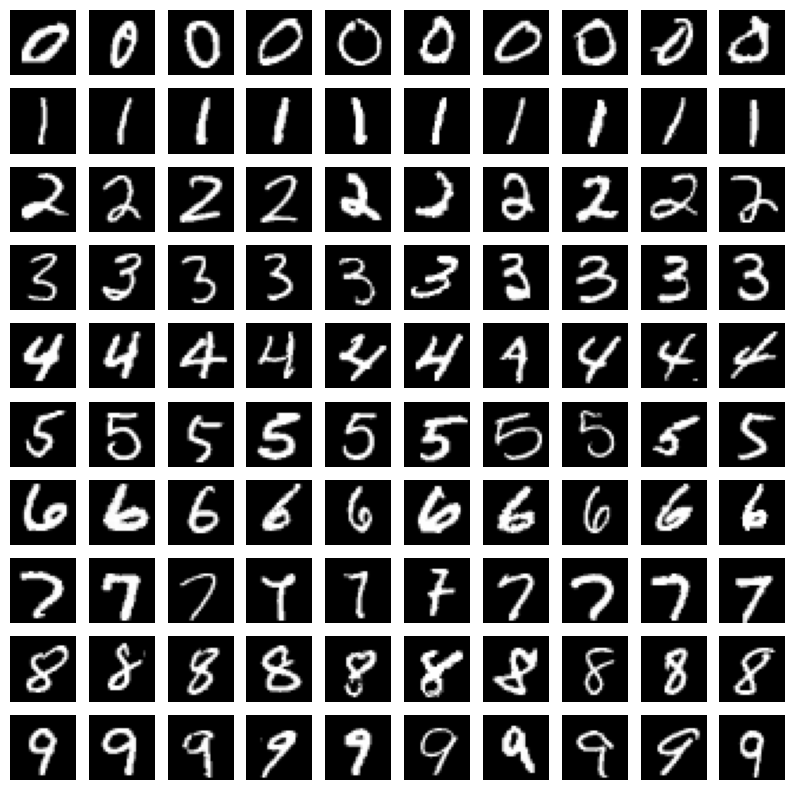

In [6]:
import random
import matplotlib.pyplot as plt

# Get a list of 10 random images for each digit
mnist_root = '../../training-data/mnist/'

def example_images(digit):
    return [Image.open(f'{mnist_root}/{digit}/{fn}') for fn in random.choices(os.listdir(f'{mnist_root}/{digit}'), k=10)]

all_digit_examples = list(map(example_images, range(10)))
fig, axs = plt.subplots(10, 10, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(all_digit_examples[i // 10][i % 10], cmap='gray')
    ax.axis('off')

plt.show()

## Create the DataLoaders

In [29]:
from fastai.vision.all import *

dls = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
).dataloaders("../../training-data/mnist/", bs=64)

## Show an example batch

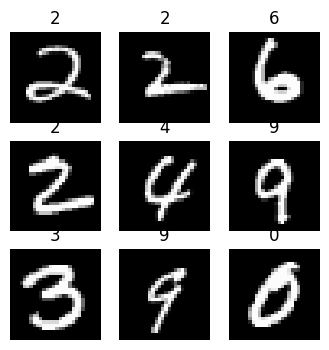

In [30]:
dls.show_batch(max_n=9, figsize=(4,4))

## Fit the model

In [31]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.837205,0.497270,0.151750,01:07
1,0.240521,0.147923,0.046917,01:04
2,0.135352,0.090582,0.025917,01:05
3,0.103502,0.070525,0.020417,01:05
4,0.080209,0.067068,0.019167,01:05
5,0.065734,0.058954,0.017083,01:05
6,0.059743,0.055479,0.016083,01:05
7,0.047925,0.053767,0.015583,01:05
8,0.034945,0.051897,0.014833,01:05
9,0.044135,0.051308,0.014750,01:05


## Examine our model

Before unpacking the results, let's see how we did.  The error rate is under 1.5%. In the confusion matrix, the values represent whether each digit was predicted correctly or incorrectly. The rows are the actual digits whereas the columns are the predicted digits. If actual and predicted are equal, the image counts towards a matrix element on the diagonal.

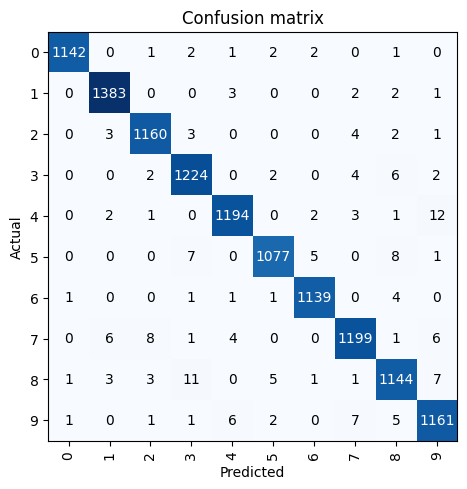

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The largest off-diagonal values are for the digit 4 being incorrectly predicted as a 9, and for the digit 8 being incorrectly predicted as a 3. This makes sense: these digits can be visually similar.

Another way to measure our performance is by looking at the top losses. These are images where the model either had a low confidence, or even worse, had a high confidence but was actually wrong.

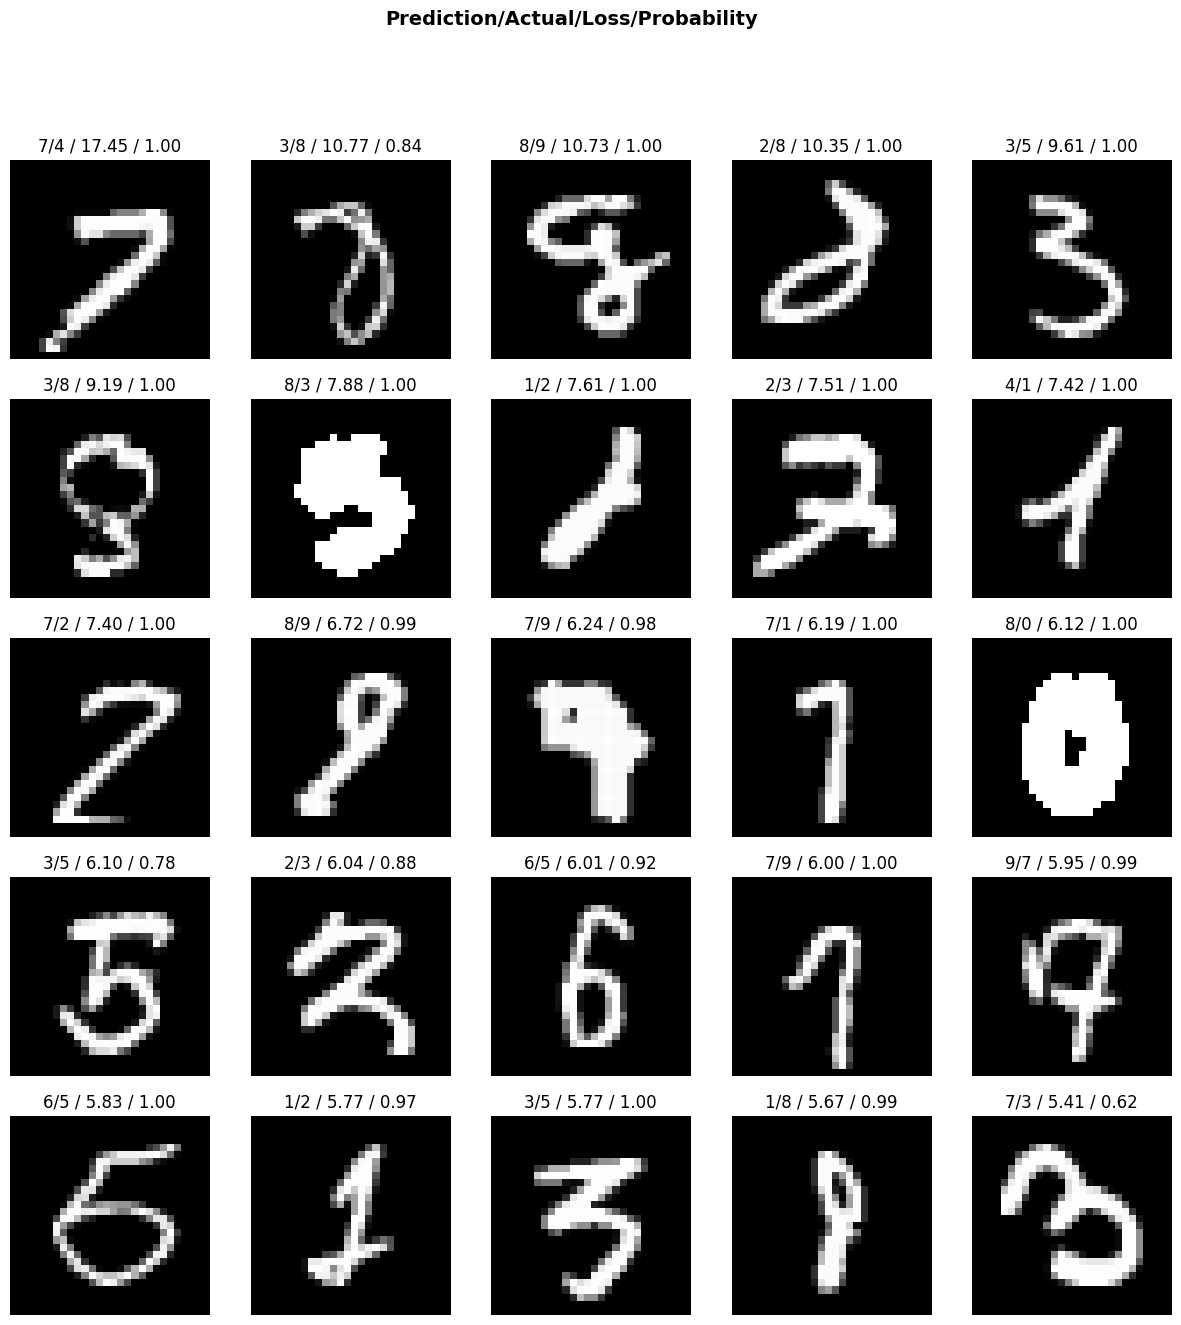

In [37]:
interp.plot_top_losses(25, nrows=5)

It's fair to say that many of these are challenging to tell apart, even for a human. Our model is doing pretty well.

## Use our model for predictions

Let's now peek under the hood. How does the calculation actually work, and how did we get there? Let's start by loading an image and running it through the model. To do so, we open a random image file and turn it into a tensor. We then pass it to `learn.predict()`. This gives us the predicted digit, and a list of probabilities for whether the image represents each possible digit.

Actual digit: 8, predicted digit: 8
Probability that digit is 0: 0.000001
Probability that digit is 1: 0.000000
Probability that digit is 2: 0.000002
Probability that digit is 3: 0.000119
Probability that digit is 4: 0.000007
Probability that digit is 5: 0.001078
Probability that digit is 6: 0.000090
Probability that digit is 7: 0.000001
Probability that digit is 8: 0.998679
Probability that digit is 9: 0.000023


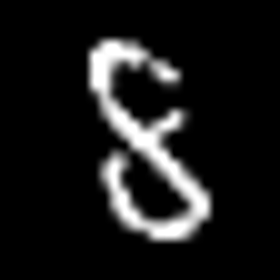

In [63]:
digit = random.choice(range(10))
filename = random.choice(os.listdir(f'{mnist_root}/{digit}'))
image_path = f'{mnist_root}/{digit}/{filename}'
image = Image.open(image_path)
prediction = learn.predict(tensor(image))

print(f'Actual digit: {digit}, predicted digit: {prediction[0]}')
for i, prob in enumerate(prediction[2]):
    print(f'Probability that digit is {i}: {prob:.6f}')

image.resize((280, 280))

## How inputs and outputs are represented

Let's unpack this further. In order to feed our image into the model, we first had to turn it into a PyTorch tensor so that PyTorch can run the calculations efficiently on the GPU. What does the tensor actually look like?

In [65]:
image_t = tensor(image)
print(f'Image shape: {image_t.shape}')
df = pd.DataFrame(image_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

Image shape: torch.Size([28, 28])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,42,217,254,153,129,10,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,254,253,253,253,254,172,13,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,254,253,149,56,156,56,167,147,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,254,253,56,0,0,0,98,253,202,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,243,248,50,0,0,0,0,51,51,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,66,209,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Our image is a rank-2 tensor of 28x28 values (one representing greyscale each pixel), where larger values whites and smaller values represent black. What does `learn.predict()` do with this? Let's take a look at the data returned:

In [66]:
learn.predict(image_t)

('8',
 tensor(8),
 tensor([6.7344e-07, 3.9815e-07, 1.6794e-06, 1.1853e-04, 6.9879e-06, 1.0782e-03,
         9.0087e-05, 1.0530e-06, 9.9868e-01, 2.2864e-05]))

We have the prediction as a category, the prediction as a rank-1 tensor of dimension 1, and the probabilities for each digit as a rank-1 tensor of dimension 10. Our neural net has computed a rank-1 tensor with dimensions equal to the number of categories in our data (10, one for each digit) and given us the category with the largest probability.

## Create a dataset from scratch

Let's try to build a neural net which maps images to probability tensors. In a perfect world, the probabilities for each digit would be 1 for the actual digit and 0 for all other possible digits.

In [91]:
ideal_digit_probability_tensors = list(
    map(
        lambda digit: tensor([1 if i == digit else 0 for i in range(10)]).float(),
        range(10)
    )
)

for i, probability_tensor in enumerate(ideal_digit_probability_tensors):
    print(f'Probability tensor for digit {i}: {probability_tensor}')

Probability tensor for digit 0: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Probability tensor for digit 1: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
Probability tensor for digit 2: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
Probability tensor for digit 3: tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
Probability tensor for digit 4: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
Probability tensor for digit 5: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
Probability tensor for digit 6: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
Probability tensor for digit 7: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
Probability tensor for digit 8: tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
Probability tensor for digit 9: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


Before we can experiment further, we need to load our dataset. For simplicity, and because the dataset is small enough to allow it, we simply load it all into memory. A dataset is simply a list of tuples of inputs and outputs.

In [117]:
import itertools

def image_to_tensor(image_path):
    return (tensor(Image.open(image_path)).float() / 255).reshape(-1)

def dataset_item(digit, image_path):
    return (image_to_tensor(image_path), ideal_digit_probability_tensors[digit])

# Gets all dataset items for a single digit
def get_dset_items(digit):
    return [dataset_item(digit, f'{mnist_root}/{digit}/{fn}') for fn in os.listdir(f'{mnist_root}/{digit}')]

# Gets all the available filenames for all digits in a single list
dset = list(itertools.chain(*[get_dset_items(i) for i in range(10)]))

Let's explore a random item from the data we've loaded.

In [123]:
dset_item = random.choice(dset)
for i, prob in enumerate(dset_item[1]):
    print(f'Probability that digit is {i}: {prob:.6f}')
df = pd.DataFrame(dset_item[0].reshape(28, 28))
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

Probability that digit is 0: 0.000000
Probability that digit is 1: 0.000000
Probability that digit is 2: 0.000000
Probability that digit is 3: 0.000000
Probability that digit is 4: 0.000000
Probability that digit is 5: 0.000000
Probability that digit is 6: 0.000000
Probability that digit is 7: 1.000000
Probability that digit is 8: 0.000000
Probability that digit is 9: 0.000000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047059,0.184314,0.184314,0.184314,0.419608,0.588235,0.588235,0.882353,1.000000,0.996078,0.309804,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105882,0.368627,0.686275,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.141176,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.678431,0.992157,0.992157,0.992157,0.964706,0.850980,0.850980,0.709804,0.447059,0.611765,0.992157,0.788235,0.062745,0.000000,0.000000,0.000000,0.000000,0.000000


Now let's split our data into a training dataset and a validation dataset. We'll first shuffle the list of items we already have with a known seed.

In [124]:
rng = random.Random(42)
rng.shuffle(dset)

## Creating the `DataLoaders`

Next we split the dataset into two sections: the training set and the validation set. We create an instance of `DataLoader` for each of these. A `DataLoader` is going to feed batches of data into our optimisation loop.

In [210]:
dset_size = len(dset)
train_size = int(dset_size * 0.8)
train_dset = dset[:train_size]
valid_dset = dset[train_size:]

train_dl = DataLoader(train_dset, batch_size=64)
valid_dl = DataLoader(valid_dset, batch_size=64)

Let's look at the shape of the data coming back from our training data loader:

In [211]:
x_batch, y_batch = next(iter(train_dl))

print(f'x_batch shape: {x_batch.shape}')
print(f'y_batch shape: {y_batch.shape}')

x_batch shape: torch.Size([64, 784])
y_batch shape: torch.Size([64, 10])


## A simpler neural net

As expected, we have a 64-image batch (where each batch is a 28*28-element column of our rank-2 tensor). We also have a 64x10 tensor containing the ideal probability values for each digit in the 64-digit batch.

In our training example above, we used `resnet34`, a 34-layer neural network for image recognition. Let's try something simpler: a 2 layer neural network. We'll define it first and then unpack what it's doing.

In [221]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30), # we have 28*28 input features and 30 output features
    nn.ReLU(), # ReLU is the activation function
    nn.Linear(30,10) # we have 30 input features from the previous layer and 10 output features
)

Let's try applying this to a single item in our training dataset. As we expect, we get 10 values on the other side. These would represent the probabilities that the image is a given digit, but they are totally random as we've not optimised our parameters.

In [215]:
simple_net(train_dset[0][0]).sigmoid()

tensor([0.5347, 0.5185, 0.5369, 0.5097, 0.4834, 0.5133, 0.5563, 0.4739, 0.5019,
        0.4355], grad_fn=<SigmoidBackward0>)

If we apply this to a 64-item batch returned by our training `DataLoader`, the calculation is broadcast to each item in the batch and we get a 64x10 rank-2 tensor.

In [216]:
simple_net(x_batch).shape

torch.Size([64, 10])

## Training our `simple_net`

We use the `Learner` class from `fastai` to train our `simple_net` as follows:

In [222]:
from fastai.learner import Learner
from torch.nn import CrossEntropyLoss

simple_dls = DataLoaders(train_dl, valid_dl)

learn_simple = Learner(
    simple_dls,
    simple_net,
    loss_func=CrossEntropyLoss(),
    metrics=accuracy_multi)
learn_simple.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.334105,0.305847,0.817908,00:00
1,0.226643,0.220060,0.839358,00:00
2,0.177801,0.178681,0.857700,00:00
3,0.160643,0.172609,0.867808,00:00
4,0.144512,0.181980,0.893075,00:00
5,0.137203,0.186078,0.906200,00:00
6,0.113290,0.183420,0.924775,00:00
7,0.105830,0.187940,0.928983,00:00
8,0.092517,0.181343,0.941050,00:00
9,0.088990,0.173747,0.943533,00:00


## Testing the `simple_net`

We see the accuracy of our predictions improve and the loss go down as expected. We'll unpack `CrossEntropyLoss` in a second, but for now, let's pick a random item from the validation dataset and test our predictions:

In [237]:
import torch.nn.functional as F

x_test, y_test = random.choice(valid_dset)

output = simple_net(x_test)
probabilities = F.softmax(output, dim=0)
prediction = probabilities.argmax()

print(f'Actual digit: {y_test.argmax()}, predicted digit: {prediction}')

for i, prob in enumerate(probabilities):
    print(f'Probability that digit is {i}: {prob:.6f}')

df = pd.DataFrame(x_test.reshape(28, 28))
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

Actual digit: 3, predicted digit: 3
Probability that digit is 0: 0.000000
Probability that digit is 1: 0.000000
Probability that digit is 2: 0.000000
Probability that digit is 3: 0.981229
Probability that digit is 4: 0.000000
Probability that digit is 5: 0.018750
Probability that digit is 6: 0.000000
Probability that digit is 7: 0.000000
Probability that digit is 8: 0.000000
Probability that digit is 9: 0.000021


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062745,0.211765,0.552941,0.552941,0.552941,0.650980,0.992157,0.796078,0.752941,0.650980,0.992157,0.403922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.847059,0.988235,0.988235,0.988235,0.992157,0.988235,0.988235,0.988235,0.992157,0.988235,0.988235,0.988235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.658824,0.658824,0.313726,0.415686,0.219608,0.219608,0.219608,0.709804,0.992157,0.988235,0.988235,0.839216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101961,0.588235,0.976471,0.992157,0.890196,0.403922,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.360784,0.847059,0.992157,0.894118,0.592157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Softmax and Cross-Entropy Loss

Softmax is a function over a vector of values:

$$ f(s)_i = \frac{e^{s_i}}{\sum_{j}{e^{s_j}}} $$

This has the effect of ensuring that all values in the vector add up to one, and that they are all between 0 and 1.

Cross-entropy loss is a measure which compares two probability distributions and decreases the more similar they are (with 0 indicating that they are equal). For our probability distribution $f(s)_i$, it may be computed as follows:

$$ CE = - \sum_{i}{t_{i} \log{f(s)_i}} $$

Let's see this in action.

In [248]:
logits = torch.rand(10) * 20 - 10 # create a random tensor with values between -10 and 10
probability_distr = F.softmax(logits, dim=0) # apply softmax to the logits

print(f'Logits: {logits}')
print(f'Probability distribution: {probability_distr}')
print(f'Sum of probabilities: {probability_distr.sum()}')

Logits: tensor([ 6.8627, -0.4434,  1.4643,  1.3323, -3.0565, -1.9472,  5.8132, -1.1937,
         3.5289, -0.8440])
Probability distribution: tensor([7.1637e-01, 4.8099e-04, 3.2410e-03, 2.8400e-03, 3.5260e-05, 1.0693e-04,
        2.5083e-01, 2.2714e-04, 2.5544e-02, 3.2224e-04])
Sum of probabilities: 1.0


For more on cross-entropy loss, check out the [following article](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

The key takeaway here is that by using Softmax, we convert a vector of arbitrary values into a vector of probabilities which add up to 1, and we can optimise the parameters of our neural network by adjusting them to minimise cross-entropy loss between our predicted and target probabilitiy distributions.

## Calculating gradients

In order to minimise our loss function, we are going to use gradient descent. To do that, we need to compute the partial derivatives of the loss with respect to each neural net parameter. We first express our neural network as a function of parameters initialised between 0 and 1. We call the `requires_grad_()` function on our parameter tensors as we need PyTorch to compute derivatives with respect to them.

In [320]:
def init_params(size):
    return (torch.randn(size)).requires_grad_()

layer_1_weights = init_params((28*28, 30)) # 28*28 input features and 30 output features
layer_1_bias = init_params(30) # biases are always the same size as the output features
layer_2_weights = init_params((30, 10)) # 30 input features from the previous layer and 10 output features
layer_2_bias = init_params(10) # biases are always the same size as the output features

# forward pass through the network is simply matrix multiplication, addition, and ReLU
# note that the input to the network is a tensor of shape (28*28, batch_size), and
# the output is a tensor of shape (10, batch_size). The batch_size is the number of
# images in the batch, and the calculation will be broadcast to all images in the batch.
def simple_net_v2(xb):
    layer_1 = xb @ layer_1_weights + layer_1_bias
    layer_1 = layer_1.max(tensor(0.0)) # ReLU
    layer_2 = layer_1 @ layer_2_weights + layer_2_bias
    return layer_2

Let's now try out our new `simple_net_v2` function before fitting the parameters.

In [321]:
logits = simple_net_v2(x_batch[0])
probabilities = F.softmax(logits, dim=0)
prediction = probabilities.argmax()

print(f'Actual digit: {y_batch[0].argmax()}, predicted digit: {prediction}')
for i, prob in enumerate(probabilities):
    print(f'Probability that digit is {i}: {prob:.6f}')

Actual digit: 5, predicted digit: 8
Probability that digit is 0: 0.000000
Probability that digit is 1: 0.000000
Probability that digit is 2: 0.000000
Probability that digit is 3: 0.000000
Probability that digit is 4: 0.000000
Probability that digit is 5: 0.000000
Probability that digit is 6: 0.000000
Probability that digit is 7: 0.000000
Probability that digit is 8: 0.999646
Probability that digit is 9: 0.000354


Let's now compute the cross-entropy loss for our probability distribution.

In [322]:
loss_func = CrossEntropyLoss()
loss = loss_func(simple_net_v2(x_batch[0]), y_batch[0])

We can now back-propagate the calculation of the loss to compute the gradient with respect to the parameters in the model.

In [323]:
loss.backward()

If we examine the `.grad` attribute on `layer_2_bias`, we can indeed see that it is now populated.

In [324]:
layer_2_bias.grad

tensor([ 7.1180e-20,  0.0000e+00,  8.4927e-25,  0.0000e+00,  0.0000e+00,
        -1.0000e+00,  6.2992e-12,  1.9324e-26,  9.9965e-01,  3.5360e-04])

## Adjusting parameters

Next, we tweak the parameters in proporition to the gradient with the aim of minimising the loss. We multiply the gradient by a small coefficient to avoid overshooting.

In [325]:
learning_rate = 1e-2

layer_1_weights.data -= layer_1_weights.grad * learning_rate
layer_1_bias.data -= layer_1_bias.grad * learning_rate
layer_2_weights.data -= layer_2_weights.grad * learning_rate
layer_2_bias.data -= layer_2_bias.grad * learning_rate

# zero out the gradients, otherwise they will accumulate
layer_1_weights.grad = None
layer_1_bias.grad = None
layer_2_weights.grad = None
layer_2_bias.grad = None

Now, we do this in batches from the `DataLoaders` and we do it in a loop for 200 epochs.

In [326]:
for epoch in range(200):
    losses = []

    for xb, yb in train_dl:
        # forward pass
        outputs = simple_net_v2(xb)

        # calculate the loss
        loss = loss_func(outputs, yb)

        # backward pass
        loss.backward()

        # update the weights and biases
        layer_1_weights.data -= layer_1_weights.grad * learning_rate
        layer_1_bias.data -= layer_1_bias.grad * learning_rate
        layer_2_weights.data -= layer_2_weights.grad * learning_rate
        layer_2_bias.data -= layer_2_bias.grad * learning_rate

        # zero out the gradients, otherwise they will accumulate
        layer_1_weights.grad = None
        layer_1_bias.grad = None
        layer_2_weights.grad = None
        layer_2_bias.grad = None

        losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}, Loss: {tensor(losses).mean():.6f}')

Epoch: 10, Loss: 0.782638
Epoch: 20, Loss: 0.600959
Epoch: 30, Loss: 0.517777
Epoch: 40, Loss: 0.468163
Epoch: 50, Loss: 0.433773
Epoch: 60, Loss: 0.407410
Epoch: 70, Loss: 0.386320
Epoch: 80, Loss: 0.369032
Epoch: 90, Loss: 0.354497
Epoch: 100, Loss: 0.342074
Epoch: 110, Loss: 0.331267
Epoch: 120, Loss: 0.321702
Epoch: 130, Loss: 0.313226
Epoch: 140, Loss: 0.305651
Epoch: 150, Loss: 0.298839
Epoch: 160, Loss: 0.292668
Epoch: 170, Loss: 0.286974
Epoch: 180, Loss: 0.281777
Epoch: 190, Loss: 0.276978
Epoch: 200, Loss: 0.272545


As expected, our loss is getting smaller with each epoch!

## Testing against the validation set

Next, we test our optimised `simple_net_v2`:


In [327]:
test_losses = []
n_accurate = 0
n_total = 0

for xb, yb in valid_dl:
    outputs = simple_net_v2(xb)

    predicted_y = F.softmax(outputs, dim=1).argmax(dim=1)
    expected_y = yb.argmax(dim=1)

    n_accurate += (predicted_y == expected_y).float().sum()
    n_total += len(expected_y)

    loss = loss_func(outputs, yb)
    test_losses.append(loss.item())

print(f'Loss: {tensor(test_losses).mean():.6f}, Accuracy: {n_accurate / n_total:.6f}')

Loss: 0.288692, Accuracy: 0.914833


We've successfully trained our neural network to an accuracy of 91%, and without using `fastai`!